###### Imports

In [1]:
import os
import torch
import numpy as np
import pandas as pd

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

from mlPlayGround.generative.normFlow import normFlowModule, normFlowSequential, nvpBatchNorm2d, realNVPCouplingLayer, realNonVolumePreserving

In [2]:
cudaavailable = torch.cuda.is_available()
mpsavailable = torch.backends.mps.is_available()
curr_device = torch.cuda.current_device()

device = torch.device("cuda" if cudaavailable else "mps" if mpsavailable else "cpu")
device_count = torch.cuda.device_count() 
device_name =  torch.cuda.get_device_name(0)

print(f'Cuda available: {cudaavailable}')
print(f'Current device: {curr_device}')
print(f'Device: {device}')
print(f'Device count: {device_count}')
print(f'Device name: {device_name}')

Cuda available: True
Current device: 0
Device: cuda
Device count: 1
Device name: NVIDIA GeForce GTX 970


###### Functions

In [3]:
class rsBasicBlock(nn.Module):
    expansion: int = 1

    def __init__(self, inplanes: int, planes: int, stride: int = 1, norm_layer = None) -> None:
        super(rsBasicBlock, self).__init__()
        if norm_layer is None:
            # norm_layer = nn.BatchNorm2d
            norm_layer = nn.InstanceNorm2d

        self.relu = nn.ReLU(inplace=True)

        self.conv0 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.conv11 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn11 = norm_layer(planes)
        self.conv12 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn12 = norm_layer(planes)

        self.conv21 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn21 = norm_layer(planes)
        self.conv22 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn22 = norm_layer(planes)

        self.conv1 = nn.Conv2d(planes, inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        pre = self.conv0(x)
        
        out = self.conv11(pre)
        out = self.bn11(out)
        out = self.relu(out)
        out = self.conv12(out)
        out = self.bn12(out)
        out += pre
        pre = self.relu(out)

        out = self.conv21(pre)
        out = self.bn21(out)
        out = self.relu(out)
        out = self.conv22(out)
        out = self.bn22(out)
        out += pre
        out = self.relu(out)

        out = self.conv1(out)

        return out

In [4]:
# def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
#     """3x3 convolution with padding"""
#     return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, 
#                      padding=dilation, groups=groups, bias=False, dilation=dilation)

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(self, inplanes: int, planes: int, stride: int = 1, downsample = None, 
                 groups: int = 1, base_width: int = 64, dilation: int = 1, norm_layer = None,    ) -> None:
        super().__init__()
        if norm_layer is None:
            # norm_layer = nn.BatchNorm2d
            norm_layer = nn.InstanceNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [5]:
class MyBatchNorm2d(nn.modules.batchnorm._NormBase):
    ''' Partially based on: 
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/batchnorm.html#BatchNorm2d
        https://discuss.pytorch.org/t/implementing-batchnorm-in-pytorch-problem-with-updating-self-running-mean-and-self-running-var/49314/5 
    '''
    def __init__(self, num_features, eps=1e-5, momentum=0.005, device=None,dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype, 'affine': False, 'track_running_stats': True}
        super(MyBatchNorm2d, self).__init__(num_features, eps, momentum, **factory_kwargs)
        
    def _check_input_dim(self, input):
        if input.dim() != 4:
            raise ValueError("expected 4D input (got {}D input)".format(input.dim()))

    def forward(self, input, validation=False):
        self._check_input_dim(input)
    
        if self.training:
            # Note: Need to detatch `running_{mean,var}` so don't backwards propagate through them
            unbiased_var, tmean = torch.var_mean(input, [0, 2, 3], unbiased=True)
            mean = torch.mean(input, [0, 2, 3]) # along channel axis
            unbiased_var = torch.var(input, [0, 2, 3], unbiased=True) # along channel axis
            running_mean = (1.0 - self.momentum) * self.running_mean.detach() + self.momentum * mean
            
            # Strange: PyTorch impl. of running variance uses biased_variance for the batch calc but
            # *unbiased_var* for the running_var!
            # https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/Normalization.cpp#L190
            running_var = (1.0 - self.momentum) * self.running_var.detach() + self.momentum * unbiased_var
            
            # BK: Modification from the paper to use running mean/var instead of batch mean/var
            # change shape
            current_mean = running_mean.view([1, self.num_features, 1, 1]).expand_as(input)
            current_var = running_var.view([1, self.num_features, 1, 1]).expand_as(input)
            
            denom = (current_var + self.eps)
            y = (input - current_mean) / denom.sqrt()
            
            self.running_mean = running_mean
            self.running_var = running_var
            
            return y, -0.5 * torch.log(denom)
        else:
            current_mean = self.running_mean.view([1, self.num_features, 1, 1]).expand_as(input)
            current_var = self.running_var.view([1, self.num_features, 1, 1]).expand_as(input)
            
            if validation:
                denom = (current_var + self.eps)
                y = (input - current_mean) / denom.sqrt()
            else:
                # Reverse operation for testing
                denom = (current_var + self.eps)
                y = input * denom.sqrt() + current_mean
                
            return y, -0.5 * torch.log(denom)

In [6]:
def bottleneck_backbone(in_planes, planes):
    return nn.Sequential(nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False),
                         BasicBlock(planes, planes),
                         BasicBlock(planes, planes),
                         nn.Conv2d(planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False))
    
check_mask = {}
check_mask_device = {}
def checkerboard_mask(shape, to_device=True):
    global check_mask, check_mask_device
    if shape not in check_mask:
        check_mask[shape] = 1 - np.indices(shape).sum(axis=0) % 2
        check_mask[shape] = torch.Tensor(check_mask[shape])
        
    if to_device and shape not in check_mask_device:
        check_mask_device[shape] = check_mask[shape].to(device)
        
    return check_mask_device[shape] if to_device else check_mask[shape]

chan_mask = {}
chan_mask_device = {}
def channel_mask(shape, to_device=True):
    assert len(shape) == 3, shape
    assert shape[0] % 2 == 0, shape
    global chan_mask, chan_mask_device
    if shape not in chan_mask:
        chan_mask[shape] = torch.cat([torch.zeros((shape[0] // 2, shape[1], shape[2])),
                                      torch.ones((shape[0] // 2, shape[1], shape[2])),],
                                      dim=0)
        assert chan_mask[shape].shape == shape, (chan_mask[shape].shape, shape)
        
    if to_device and shape not in chan_mask_device:
        chan_mask_device[shape] = chan_mask[shape].to(device)
        
    return chan_mask_device[shape] if to_device else chan_mask[shape]

In [7]:
class NormalizingFlowMNist(nn.Module):
    EPSILON = 1e-5
    
    def __init__(self, num_coupling=6, num_final_coupling=4, planes=64):
        super(NormalizingFlowMNist, self).__init__()
        self.num_coupling = num_coupling
        self.num_final_coupling = num_final_coupling
        self.shape = (1, 28, 28)
        
        self.planes = planes
        self.s = nn.ModuleList()
        self.t = nn.ModuleList()
        self.norms = nn.ModuleList()
        
        # Learnable scalar scaling parameters for outputs of S and T
        self.s_scale = nn.ParameterList()
        self.t_scale = nn.ParameterList()
        self.t_bias = nn.ParameterList()
        self.shapes = []
      
        shape = self.shape
        for i in range(num_coupling):
            self.s.append(bottleneck_backbone(shape[0], planes))
            self.t.append(bottleneck_backbone(shape[0], planes))
            
            self.s_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_bias.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            
            self.norms.append(MyBatchNorm2d(shape[0]))
            
            self.shapes.append(shape)
           
            if i % 6 == 2:
                shape = (4 * shape[0], shape[1] // 2, shape[2] // 2)
                
            if i % 6 == 5:
                # Factoring out half the channels
                shape = (shape[0] // 2, shape[1], shape[2])
                planes = 2 * planes
       
        # Final coupling layers checkerboard
        for i in range(num_final_coupling):
            self.s.append(bottleneck_backbone(shape[0], planes))
            self.t.append(bottleneck_backbone(shape[0], planes))
            
            self.s_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_bias.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            
            self.norms.append(MyBatchNorm2d(shape[0]))
            
            self.shapes.append(shape)
           
        self.validation = False
    
    def validate(self):
        self.eval()
        self.validation = True
        
    def train(self, mode=True):
        nn.Module.train(self, mode)
        self.validation = False

    def forward(self, x):
        if self.training or self.validation:
            s_vals = []
            norm_vals = []
            y_vals = []
            
            for i in range(self.num_coupling):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape) if i % 6 < 3 else channel_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
               
                t = (self.t_scale[i]) * self.t[i](mask * x) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * x))
                y = mask * x + (1 - mask) * (x * torch.exp(s) + t)
                s_vals.append(torch.flatten((1 - mask) * s))
               
                if self.norms[i] is not None:
                    y, norm_loss = self.norms[i](y, validation=self.validation)
                    norm_vals.append(norm_loss)
                    
                if i % 6 == 2:
                    y = torch.nn.functional.pixel_unshuffle(y, 2)
                    
                if i % 6 == 5:
                    factor_channels = y.shape[1] // 2
                    y_vals.append(torch.flatten(y[:, factor_channels:, :, :], 1))
                    y = y[:, :factor_channels, :, :]
                    
                x = y
                
            # Final checkboard coupling
            for i in range(self.num_coupling, self.num_coupling + self.num_final_coupling):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
               
                t = (self.t_scale[i]) * self.t[i](mask * x) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * x))
                y = mask * x + (1 - mask) * (x * torch.exp(s) + t)
                s_vals.append(torch.flatten((1 - mask) * s))
                
                if self.norms[i] is not None:
                    y, norm_loss = self.norms[i](y, validation=self.validation)
                    norm_vals.append(norm_loss)
                
                x = y

            y_vals.append(torch.flatten(y, 1))
            
            # Return outputs and vars needed for determinant
            return (torch.flatten(torch.cat(y_vals, 1), 1),
                    torch.cat(s_vals), 
                    torch.cat([torch.flatten(v) for v in norm_vals]) if len(norm_vals) > 0 else torch.zeros(1),
                    torch.cat([torch.flatten(s) for s in self.s_scale]))
        else:
            y = x
            y_remaining = y
           
            layer_vars = np.prod(self.shapes[-1])
            y = torch.reshape(y_remaining[:, -layer_vars:], (-1,) + self.shapes[-1])
            y_remaining = y_remaining[:, :-layer_vars]
            
            # Reversed final checkboard coupling
            for i in reversed(range(self.num_coupling, self.num_coupling + self.num_final_coupling)):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
                
                if self.norms[i] is not None:
                    y, _ = self.norms[i](y)
              
                t = (self.t_scale[i]) * self.t[i](mask * y) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * y))
                x = mask * y + (1 - mask) * ((y - t) * torch.exp(-s))
               
                y = x           
          
            layer_vars = np.prod(shape)
            y = torch.cat((y, torch.reshape(y_remaining[:, -layer_vars:], (-1,) + shape)), 1)
            y_remaining = y_remaining[:, :-layer_vars]
            
            # Multi-scale coupling layers
            for i in reversed(range(self.num_coupling)):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape) if i % 6 < 3 else channel_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
              
                if self.norms[i] is not None:
                    y, _ = self.norms[i](y)
                    
                t = (self.t_scale[i]) * self.t[i](mask * y) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * y))
                x = mask * y + (1 - mask) * ((y - t) * torch.exp(-s))
               
                if i % 6 == 3:
                    x = torch.nn.functional.pixel_shuffle(x, 2)
                    
                y = x
                
                if i > 0 and i % 6 == 0:
                    layer_vars = np.prod(shape)
                    y = torch.cat((y, torch.reshape(y_remaining[:, -layer_vars:], (-1,) + shape)), 1)
                    y_remaining = y_remaining[:, :-layer_vars]
            
            assert np.prod(y_remaining.shape) == 0
            
            return x

In [8]:
PI = torch.tensor(np.pi).to(device)
def loss_fn(y, s, norms, scale, batch_size):
    # -log(zero-mean gaussian) + log determinant
    # -log p_x = log(pz(f(x))) + log(det(\partial f/\partial x))
    # -log p_x = 0.5 * y**2 + s1 + s2 + ... + batch_norm_scalers + l2_regularizers(scale)
    logpx = -torch.sum(0.5 * torch.log(2 * PI) + 0.5 * y**2)
    det = torch.sum(s)
    norms = torch.sum(norms)
    reg = 5e-5 * torch.sum(scale ** 2)
    loss = -(logpx + det + norms) + reg
    return torch.div(loss, batch_size), (-logpx, -det, -norms, reg)

###### MNIST

In [9]:
def pre_process(x):
    # Convert back to integer values
    x = x * 255.
    
    # Add random uniform [0, 1] noise to get a proper likelihood estimate
    # https://bjlkeng.github.io/posts/a-note-on-using-log-likelihood-for-generative-models/
    x = x + torch.rand(x.shape)

    # Apply transform to deal with boundary effects (see realNVP paper)
    #x = torch.logit(0.05 + 0.90 * x / 256)
    #return x
    return x / 255

def post_process(x):
    # Convert back to integer values
    #return torch.clip(torch.floor(256 / 0.90 * (torch.sigmoid(x) - 0.05)), min=0, max=255) / 255
    return torch.clip(x, min=0, max=1)

In [10]:
class imageOnlyDataset(torch.utils.data.Dataset):
    '''
    Class to extract only the images as do do not need labels to train the VAE
    '''
    def __init__(self, original, index):
        self.__original = original
        self.__index = index

    @property
    def original(self):
        return self.__original

    @property
    def index(self):
        return self.__index

    def __len__(self):
        return len(self.original)

    def __getitem__(self, index):
        return self.original[index][self.index]

In [11]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_data = datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

image_data = imageOnlyDataset(train_data + test_data, 0)
print(len(train_data), len(test_data), len(image_data))

60000 10000 70000


In [12]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size, report_iters=10, num_pixels=28*28):
    size = len(dataloader)
    prev = []
    for batch, (X, _) in enumerate(dataloader):
        # Transfer to GPU
        X = pre_process(X)
        X = X.to(device)
        
        # Compute prediction and loss
        y, s, norms, scale = model(X)
        loss, comps = loss_fn(y, s, norms, scale, batch_size)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        prev = [(name, x, x.grad) for name, x in model.named_parameters(recurse=True)]
        optimizer.step()

        if batch % report_iters == 0:
            loss, current = loss.item(), batch
            # Account for x/255 preprocessing
            loss += num_pixels * np.log(255)
            print(f"loss: {loss:.2f} = -logpx[{comps[0]:.1f}], -det[{comps[1]:.1f}], -norms[{comps[2]:.1f}], reg[{comps[3]:.4f}]"
                  f"; bits/pixel: {loss / num_pixels / np.log(2):>.2f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, num_pixels=28*28):
    size = len(dataloader)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        model.validate()
        for X, _ in dataloader:
            X = pre_process(X)
            X = X.to(device)
            y, s, norms, scale = model(X)
            loss, _ = loss_fn(y, s, norms, scale, batch_size)
            test_loss += loss
            
        model.train()

    
    test_loss /= num_batches
    # Account for x/255 preprocessing
    test_loss += num_pixels * np.log(255)
    print(f"Test Error: \n Avg loss: {test_loss:.2f}; {test_loss / num_pixels / np.log(2):.2f} \n")
    return test_loss

In [13]:
learning_rate = 0.0005
batch_size = 50
epochs = 3

model = NormalizingFlowMNist(num_coupling=12, num_final_coupling=4, planes=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [14]:
# model.train()

# best_validation = None
# PATH = '../checkpoints/'
# for t in range(epochs):
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     print(f"Epoch {t+1}\n-------------------------------")
#     train_loop(train_loader, model, loss_fn, optimizer, batch_size)
#     validation_loss = test_loop(test_loader, model, loss_fn)
    
#     torch.save({'epoch': t, 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(), 'loss': validation_loss}, 
#                PATH + f'mnist-{t}.model')
    
#     if best_validation is None or validation_loss < best_validation:
#         best_validation = validation_loss
#         best_path = PATH + f'mnist-{t}.model'
    
#     scheduler.step()

# print("Done - ", best_path)

In [15]:
model = NormalizingFlowMNist(num_coupling=12, num_final_coupling=4, planes=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

checkpoint = torch.load('../checkpoints/mnist-2.model')
# checkpoint = torch.load(best_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

C:\Users\Raghav\AppData\Local\Temp\ipykernel_5004\194373896.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../checkpoints/mnist-2.model')


###### Comparison

In [16]:
def copyConvWeights(f, t):
    t.weight = f.weight
    
def copyNormWeights(f, t):
    t.running_mean, t.running_var = f.running_mean, f.running_var

def copyBasicBlock(bb, rsbb):
    copyConvWeights(bb[0], rsbb.conv0)
    
    copyConvWeights(bb[1].conv1, rsbb.conv11)  # bias is None!
    copyNormWeights(bb[1].bn1, rsbb.bn11)
    copyConvWeights(bb[1].conv2, rsbb.conv12)  # bias is None!
    copyNormWeights(bb[1].bn2, rsbb.bn12)

    copyConvWeights(bb[2].conv1, rsbb.conv21)  # bias is None!
    copyNormWeights(bb[2].bn1, rsbb.bn21)
    copyConvWeights(bb[2].conv2, rsbb.conv22)  # bias is None!
    copyNormWeights(bb[2].bn2, rsbb.bn22)

    copyConvWeights(bb[3], rsbb.conv1)  # bias is None!

In [17]:
# load data to play around with
model.eval()

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False) #shuffle=True)
for x, _ in train_loader:
    x_pre = pre_process(x).to(device)
    break

In [18]:
# verify the checkerboard layers
i = 0
shape = model.shapes[i]
mask_type = "check" if i < 3 else "channel"
mask_type

# evaluate the model layer
mask = checkerboard_mask(shape) if i < 3 else channel_mask(shape)
mask = mask if i % 2 == 0 else (1 - mask)
_ = mask.to(device)

x = x_pre if i < 3 else torch.nn.functional.pixel_unshuffle(x_pre, 2)
t = model.t_scale[i] * model.t[i](mask * x) + model.t_bias[i]
s = model.s_scale[i] * torch.tanh(model.s[i](mask * x))
y = mask * x + (1 - mask) * (x * torch.exp(s) + t)

# create a coupling layer and copy the weights
c = realNVPCouplingLayer(rsBasicBlock(shape[0], 64), rsBasicBlock(shape[0], 64), shape, mask_type, i%2==1)
c.to(device)

copyBasicBlock(model.s[i], c.s)
copyBasicBlock(model.t[i], c.t)
c.sScale = model.s_scale[i]
c.tScale = model.t_scale[i]
c.tBias = model.t_bias[i]

print(torch.max(torch.abs(c(x)[0] - y)))
print(torch.max(torch.abs(c(x)[1] - torch.sum(torch.flatten((1 - mask) * s, 1), 1))))

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0002, device='cuda:0', grad_fn=<MaxBackward1>)


In [19]:
# verify the checkerboard layers
i = 3
shape = model.shapes[i]
mask_type = "check" if i < 3 else "channel"
mask_type

# evaluate the model layer
mask = checkerboard_mask(shape) if i < 3 else channel_mask(shape)
mask = mask if i % 2 == 0 else (1 - mask)
_ = mask.to(device)

x = x_pre if i < 3 else torch.nn.functional.pixel_unshuffle(x_pre, 2)
t = model.t_scale[i] * model.t[i](mask * x) + model.t_bias[i]
s = model.s_scale[i] * torch.tanh(model.s[i](mask * x))
y = mask * x + (1 - mask) * (x * torch.exp(s) + t)

# create a coupling layer and copy the weights
c = realNVPCouplingLayer(rsBasicBlock(shape[0], 64), rsBasicBlock(shape[0], 64), shape, mask_type, i%2==1)
c.to(device)

copyBasicBlock(model.s[i], c.s)
copyBasicBlock(model.t[i], c.t)
c.sScale = model.s_scale[i]
c.tScale = model.t_scale[i]
c.tBias = model.t_bias[i]

print(torch.max(torch.abs(c(x)[0] - y)))
print(torch.max(torch.abs(c(x)[1] - torch.sum(torch.flatten((1 - mask) * s, 1), 1))))

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0002, device='cuda:0', grad_fn=<MaxBackward1>)


In [20]:
# check the norm flow sequential layer
shape = model.shapes[0]
c1 = realNVPCouplingLayer(rsBasicBlock(shape[0], 64), rsBasicBlock(shape[0], 64), shape, 'check', False)
c2 = realNVPCouplingLayer(rsBasicBlock(shape[0], 64), rsBasicBlock(shape[0], 64), shape, 'check', True)
c3 = realNVPCouplingLayer(rsBasicBlock(shape[0], 64), rsBasicBlock(shape[0], 64), shape, 'check', False)

copyBasicBlock(model.s[0], c1.s)
copyBasicBlock(model.t[0], c1.t)
c1.sScale = model.s_scale[0]
c1.tScale = model.t_scale[0]
c1.tBias = model.t_bias[0]

copyBasicBlock(model.s[1], c2.s)
copyBasicBlock(model.t[1], c2.t)
c2.sScale = model.s_scale[1]
c2.tScale = model.t_scale[1]
c2.tBias = model.t_bias[1]

copyBasicBlock(model.s[2], c3.s)
copyBasicBlock(model.t[2], c3.t)
c3.sScale = model.s_scale[2]
c3.tScale = model.t_scale[2]
c3.tBias = model.t_bias[2]

nfs = normFlowSequential(c1, c2, c3)
_ = nfs.to(device)

x0 = x_pre
x1, l1 = c1(x0)
x2, l2 = c2(x1)
x3, l3 = c3(x2)

print(torch.max(torch.abs(nfs(x_pre)[0] - x3)))
print(torch.max(torch.abs(nfs(x_pre)[1] - l1 - l2 - l3)))

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.5259e-05, device='cuda:0', grad_fn=<MaxBackward1>)


In [21]:
learning_rate = 0.0005
batch_size = 50
epochs = 10

model = realNonVolumePreserving(lambda i, h: rsBasicBlock(i, h), (1, 28, 28), hidden=64, nScales=2, nFinal=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
trainLoader = DataLoader(image_data, batch_size=batch_size, shuffle=True)

In [ ]:
model.trainLoop(trainLoader, optimizer, epochs)

Epoch 1
-------------------------------
totalLoss: 48658.949219 logLoss: -6956.570801 priorLoss: 55615.519531[ 5000/70000]
totalLoss: 117554.187500 logLoss: 61939.593750 priorLoss: 55614.589844[10000/70000]
totalLoss: 137646.500000 logLoss: 82024.648438 priorLoss: 55621.851562[15000/70000]
totalLoss: 117895.921875 logLoss: 62275.339844 priorLoss: 55620.578125[20000/70000]
totalLoss: 119902.945312 logLoss: 64288.492188 priorLoss: 55614.453125[25000/70000]
totalLoss: 174414.718750 logLoss: 118793.453125 priorLoss: 55621.273438[30000/70000]
totalLoss: 172200.375000 logLoss: 116578.226562 priorLoss: 55622.148438[35000/70000]
totalLoss: 170059.000000 logLoss: 114436.796875 priorLoss: 55622.210938[40000/70000]
totalLoss: 160349.187500 logLoss: 104727.328125 priorLoss: 55621.855469[45000/70000]
totalLoss: 155675.000000 logLoss: 100052.859375 priorLoss: 55622.140625[50000/70000]
totalLoss: 151838.250000 logLoss: 96216.148438 priorLoss: 55622.093750[55000/70000]
totalLoss: 150574.281250 logLoss

###### Debug

In [16]:
# DEBUG - Checkmodel[s]
model.validate()
with torch.no_grad():
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) #shuffle=True)
    for x, _ in train_loader:
        x_pre = pre_process(x).to(device)
        y, s, norms, scale = model(x_pre)
        print(y.shape)
        break

torch.Size([50, 784])


In [ ]:
model.train()
model.eval()
with torch.no_grad():
    xp = model(y)
    x_post = post_process(xp)

diff = x.to(device) - x_post
print(torch.any(torch.abs(diff) > 1 / 255))

torch.Size([50, 784])
tensor(False, device='cuda:0')


In [15]:
print(diff.shape)
for i in range(batch_size):
    if torch.any(torch.abs(diff[i]) > 1 / 255):
        #print(diff[i])
        for j in range(28):
            for k in range(28):
                if torch.any(torch.abs(diff[i, 0, j, k]) > 1 / 255):
                    print(i, 1, j, k, diff[i, 0, j, k].cpu().numpy())
                    break
        break

torch.Size([50, 1, 28, 28])


count    39200.000000
mean         0.017925
std          1.020022
min         -8.922613
25%         -0.672862
50%          0.015510
75%          0.699524
max          8.309829
dtype: float64


<Axes: >

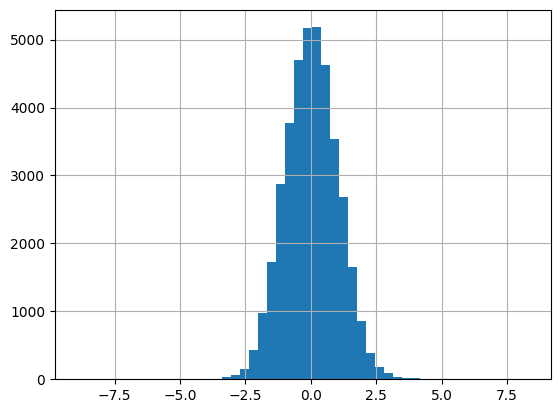

In [16]:
s = pd.Series(torch.flatten(y).cpu().numpy())
print(s.describe())
s.hist(bins=50)

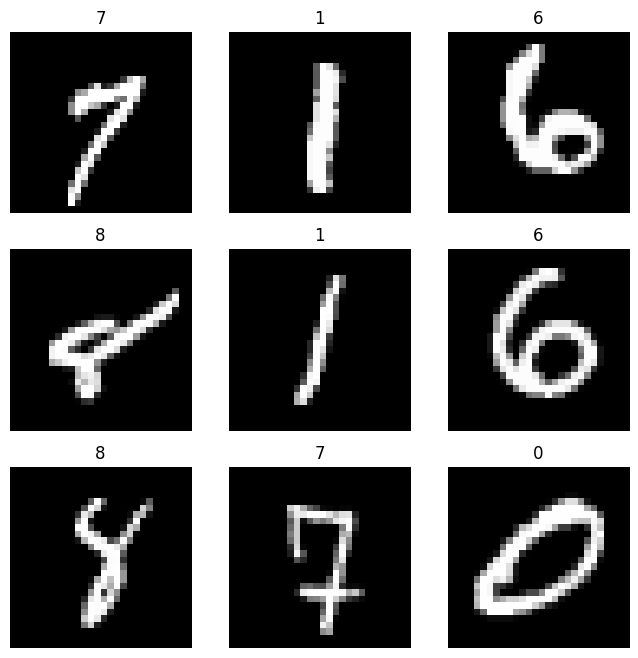

In [17]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(str(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [18]:
model.eval()
with torch.no_grad():
    X = torch.Tensor(torch.randn((1, 28 * 28 * 1))).to(device)
    Y = model(X)
    samples = post_process(Y).cpu().numpy()

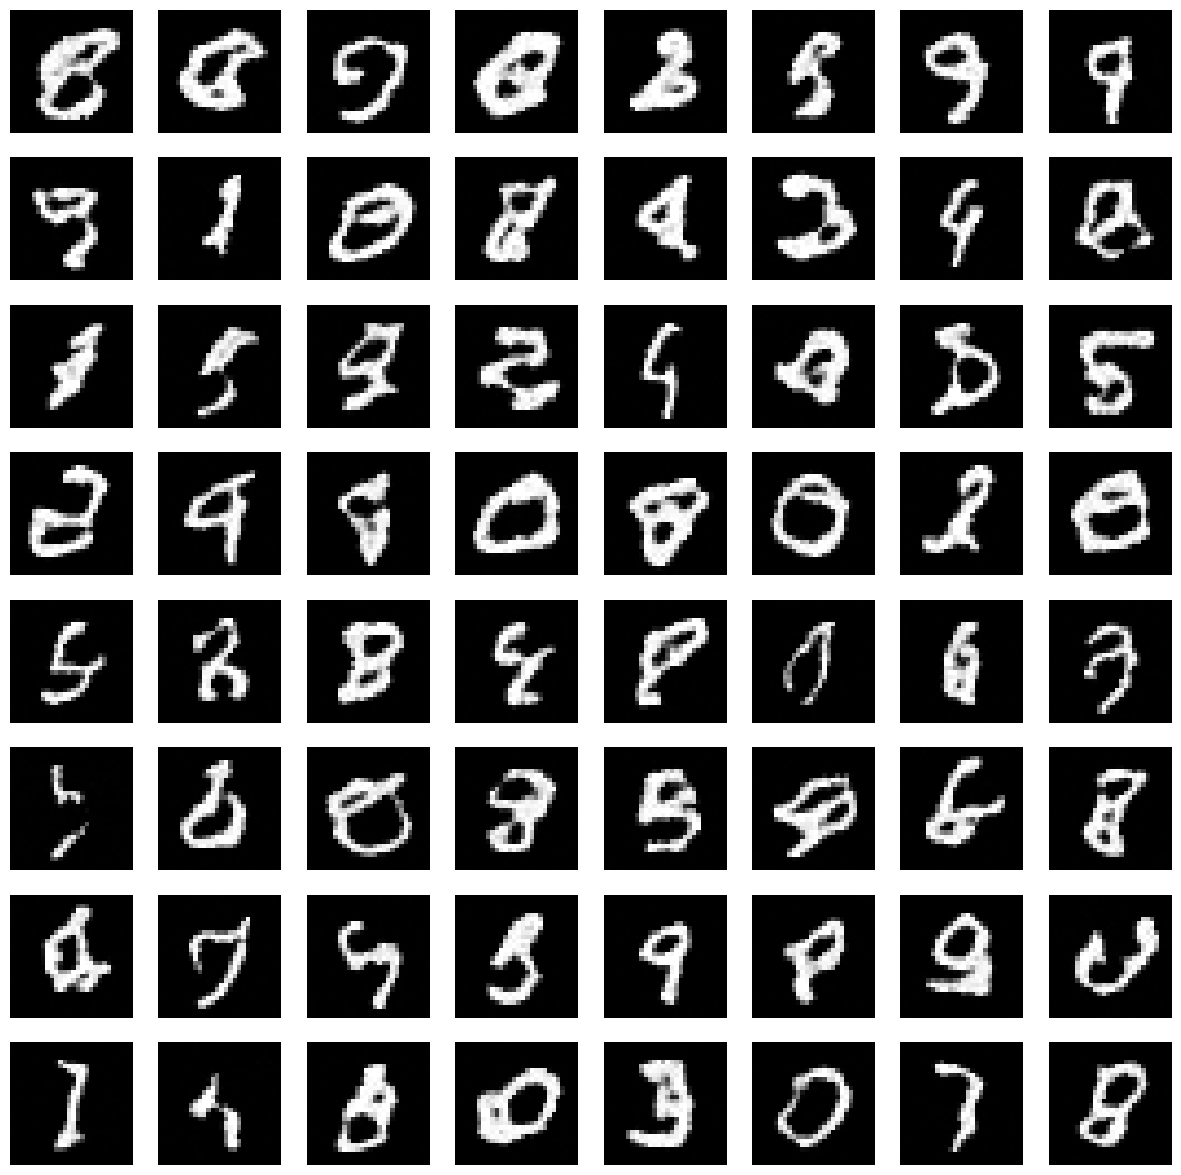

In [19]:
model.eval()

cols, rows = 8, 8
with torch.no_grad():
    X = torch.Tensor(torch.normal(torch.zeros(cols * rows, 28 * 28 * 1),
                                  torch.ones(cols * rows, 28 * 28 * 1))).to(device)
    Y = model(X)
    samples = post_process(Y).cpu().numpy()

figure = plt.figure(figsize=(15, 15))
for i in range(1, cols * rows + 1):
    img = samples[i - 1]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()